In [1]:
from __future__ import absolute_import, division

import os
import sys
import urllib, cStringIO

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64
from svgpathtools import parse_path, wsvg, Path, Line

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setup

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
import rendering_helpers as srh
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)
reload(srh)

<module 'rendering_helpers' from 'rendering_helpers.pyc'>

### experiment record

- *`pilot0`: Test UI*
    * 2 participants. 
    * Mostly fine, but found a few bugs with data saving and fixed.
- *`pilot1`: Explore prepost design*
    * N = 18+ participants. 
        * note: game '9053-d3a0c1d9-cb81-4bdd-a572-5e38b91b33e9' in pilot1 missing stroke data from the first sheep
    * experimentDesign: `prepost`
    * Is there transfer from collab phase to solo drawing?*
    * Each session contains 40 drawing trials.
    * Same 8 categories used in all sessions: ['bear','cat','duck','lion','pig','rabbit','sheep','swan'] 
    * 4 of these categories are assigned to the "collab" condition; the other 4 are assigned to the "solo" condition.
    * Each category is drawn five times. The first and fifth time, the category is drawn solo. The second through fourth time, if the object belongs to the "collab" condition, participant takes turns drawing with robot. If the object instead belongs to the "solo" condition, participant again draws on their own.
    * Every trial ends when human decides the drawing is sufficiently recognizable & clicks submit button.
    * All categories are drawn across 5 repetition cycles, wherein all categories are drawn once in a randomized order, before proceeding to next repetition cycle.
- *`pilot2`: Baseline task (collab vs. solo)*
    * N = 95 participants. 
    * experimentDesign: `baseline`
    * Same 8 categories used in all sessions: ['bear','cat','duck','lion','pig','rabbit','sheep','swan'] 
    * All 8 categories drawn both collaboratively & solo.
    * Each category is drawn four times each, in a counterbalanced order. 
- *`*pilot3`: Classifier added.*
    * N participants
    * experimentDesign: `baseline`
    * Same 8 categories used in all sessions: ['bear','cat','duck','lion','pig','rabbit','sheep','swan'] 
    * All 8 categories drawn both collaboratively & solo.
    * Each category is drawn four times each, in a counterbalanced order. 
    * Classifier results sent back to server with each finished stroke/sketch to make it much easier to do timecourse analyses
    * Classifier results sometimes provided to participant as performance/motivational feedback (to incentivize good-quality drawings).

### connect to db

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'stanford-cogsci.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['collabdraw']
coll = db['collab']

# which iteration name should we use?
iterationName = 'pilot2'

## look up number of trials
trialNumDict = {'pilot1':40, 'pilot2':32}
numTrials = trialNumDict[iterationName]

### construct tidy dataframe with game data

In [4]:
## get list of gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameID')
complete_games = [g for g in gameIDs if len(coll.find({'gameID':g}).distinct('trialNum')) == numTrials]

## filter out scribble games
scribble_games = ['8927-ed92b1cd-7048-47cf-b0fa-55460942d03f','1827-1f1b53ce-6bf0-4d36-88c7-dd4fbc5ed93d',
                 '1005-ab4289b5-846d-4ea2-95ee-84a6bb85b04e','6963-a564b891-58fd-496f-a880-4fde85ac9f12',
                 '8373-3086e308-8b53-4a3a-b517-15c7cd7ff467']
collab_broken_games = ['8084-41112791-3f53-4a48-85c0-244774e9732b','0408-5409d609-c2c2-4701-8866-15be40ae1b9e',
                      '2088-0ade8a40-789b-4311-b097-83d266899531','2179-03831158-60a4-423b-8ece-2b1b1c42191b',
                      '9554-9c1fae49-babb-4a9d-bece-073a956fbe81']
complete_games = [g for g in complete_games if g not in scribble_games]
complete_games = [g for g in complete_games if g not in collab_broken_games]


## construct tidy dataframe for all games
D = pd.DataFrame()
M = pd.DataFrame()
for g, this_gameID in enumerate(complete_games):
    print 'Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games))
    clear_output(wait=True)    
    
    ### extract sketch (contains pngString) records 
    K = coll.find({ '$and': [{'iterationName':iterationName}, {'gameID': this_gameID}, {'dataType': 'sketch'}]}).sort('time') 
    li = list(K)
    _M = pd.DataFrame(li)
    
    ## get list of records for single game and convert to tidy dataframe
    T = coll.find({ '$and': [{'iterationName':iterationName}, {'gameID': this_gameID}, {'dataType': 'stroke'}]}).sort('time')         
    li = list(T)
    _D = pd.DataFrame(li)

    ## concat with previous game's dataframe
    if D.shape[0]==0:
        D = _D
        M = _M
    else: 
        D = pd.concat([D,_D], axis=0) 
        M = pd.concat([M,_M], axis=0)

## postprocessing
D = D.drop('workerId',axis=1)
M = M.drop('workerId',axis=1)
        
## save out group dataframe to csv dir
D.to_csv(os.path.join(csv_dir,'collabdraw_stroke_{}.csv'.format(iterationName)))        
M.to_csv(os.path.join(csv_dir,'collabdraw_sketch_{}.csv'.format(iterationName)))

Analyzing game 7067-442e422f-cd21-414e-b1cc-0643487dc400 | 90 of 90


### load in group data

In [5]:
## load in stroke-level dataframe to render out source pngs (so has nifty color scheme)
D = pd.read_csv(os.path.join(csv_dir,'collabdraw_stroke_{}.csv'.format(iterationName)))
M = pd.read_csv(os.path.join(csv_dir,'collabdraw_sketch_{}.csv'.format(iterationName)))
print 'Number of unique gameIDs = {}'.format(D.gameID.nunique())

Number of unique gameIDs = 90


### render out sketches for inspection & feature extraction

In [6]:
## render out all svg
reload(srh)
for name, group in D.groupby(['gameID','trialNum']):   
        
    ## get list of svg
    this_svg, bounds = srh.make_svg_list(group,crop=True)
    
    ## construct filename
    g = np.unique(group['gameID'])[0]
    l = np.unique(group['className'])[0]
    r = np.unique(group['repetition'])[0]    
    t = np.unique(group['trialNum'])[0]
    c = np.unique(group['condition'])[0]
    s = 'both'
    e = 'pilot2'
    this_fname = '{}_{}_{}_{}_{}_{}_{}'.format(g,l,r,t,c,s,e)
    
    print 'Rendering out svg data from game: {}  trial: {}'.format(g,t)
    clear_output(wait=True)
    
    ## render to svg file
    padding = 10
    stroke_pct_canvas = 0.02 ## what fraction of image size should a stroke's width be?
    stroke_width = np.int(np.round(stroke_pct_canvas*bounds))
    
    srh.render_svg(this_svg,
                 out_dir=svg_dir,
                 viewbox=[0, 0, bounds+padding, bounds+padding],
                 stroke_width = stroke_width,
                 stroke_color = 'black',
                 out_fname= '{}.svg'.format(this_fname)) 
    
## get svg path list for rendered out svg
svg_paths = srh.generate_svg_path_list(os.path.join(sketch_dir,'svg'))    

## convert all svg to png
srh.svg_to_png(svg_paths,base_dir=sketch_dir)

convert /Users/judithfan/collabdraw/sketches/svg/9881-7594407d-025c-464f-b0e5-f3ab30bae0e5_swan_3_24_solo_both_pilot2.svg /Users/judithfan/collabdraw/sketches/png/9881-7594407d-025c-464f-b0e5-f3ab30bae0e5_swan_3_24_solo_both_pilot2.png


In [ ]:
## note: game '9053-d3a0c1d9-cb81-4bdd-a572-5e38b91b33e9' in pilot1 missing stroke data from the first sheep

### sketch-data lesion studies (render out sketches missing human/sketchrnn strokes)

In [ ]:
## collabdrawings: lesion human/sketchrnn strokes
## solodrawings: lesion odd or even strokes

#### collab drawings

In [ ]:
## render out all svg
reload(srh)
Dc = D[D['condition']=='collab']
for name, group in Dc.groupby(['gameID','trialNum','sketcherId']):  
     
    ## get list of svg
    this_svg, bounds = srh.make_svg_list(group,crop=True)
    
    ## construct filename
    g = np.unique(group['gameID'])[0]
    l = np.unique(group['className'])[0]
    r = np.unique(group['repetition'])[0]    
    t = np.unique(group['trialNum'])[0]
    c = np.unique(group['condition'])[0]
    s = np.unique(group['sketcherId'])[0]
    e = iterationName

    this_fname = '{}_{}_{}_{}_{}_{}_{}'.format(g,l,r,t,c,s,e)
    
    print 'Rendering out svg data from game: {}  trial: {}'.format(g,t)
    clear_output(wait=True)
    
    ## render to svg file
    padding = 10
    stroke_pct_canvas = 0.02 ## what fraction of image size should a stroke's width be?
    stroke_width = np.int(np.round(stroke_pct_canvas*bounds))
    
    svg_dir_partial = os.path.join(sketch_dir,'svg_collab','human_only') if s=='human' else os.path.join(sketch_dir,'svg_collab','robot_only')
    if not os.path.exists(os.path.join(sketch_dir,'svg_collab')):
        os.makedirs(os.path.join(sketch_dir,'svg_collab'))
    if not os.path.exists(svg_dir_partial):
        os.makedirs(svg_dir_partial)
    
    srh.render_svg(this_svg,
                 out_dir=svg_dir_partial,
                 viewbox=[0, 0, bounds+padding, bounds+padding],
                 stroke_width = stroke_width,
                 stroke_color = 'black',
                 out_fname= '{}.svg'.format(this_fname)) 
      
for sketcherId in ['human','robot']:    
    ## get svg path list for rendered out svg
    svg_paths = srh.generate_svg_path_list(os.path.join(sketch_dir,'svg_collab','{}_only'.format(sketcherId)))    

    ## convert all svg to png
    srh.svg_to_png(svg_paths,base_dir=sketch_dir,out_dir=os.path.join(sketch_dir,'png_collab','{}_only'.format(sketcherId)))    

#### solo drawings

In [ ]:
## render out all svg
reload(srh)
Ds = D[D['condition']=='solo']
## split strokes by odd/even to match lesion analysis on collab drawings
Ds = Ds.assign(parity=Ds['numStrokes'].apply(lambda x: 'even' if x%2==0 else 'odd')) 

In [ ]:
for name, group in Ds.groupby(['gameID','trialNum','parity']):  
     
    ## get list of svg
    this_svg, bounds = srh.make_svg_list(group,crop=True)
    
    ## construct filename
    g = np.unique(group['gameID'])[0]
    l = np.unique(group['className'])[0]
    r = np.unique(group['repetition'])[0]    
    t = np.unique(group['trialNum'])[0]
    c = np.unique(group['condition'])[0]
    s = np.unique(group['parity'])[0]
    e = iterationName

    this_fname = '{}_{}_{}_{}_{}_{}_{}'.format(g,l,r,t,c,s,e)
    
    print 'Rendering out svg data from game: {}  trial: {}'.format(g,t)
    clear_output(wait=True)
    
    ## render to svg file
    padding = 10
    stroke_pct_canvas = 0.02 ## what fraction of image size should a stroke's width be?
    stroke_width = np.int(np.round(stroke_pct_canvas*bounds))
    
    svg_dir_partial = os.path.join(sketch_dir,'svg_solo','even_only') if s=='even' else os.path.join(sketch_dir,'svg_solo','odd_only')
    if not os.path.exists(os.path.join(sketch_dir,'svg_solo')):
        os.makedirs(os.path.join(sketch_dir,'svg_solo'))
    if not os.path.exists(svg_dir_partial):
        os.makedirs(svg_dir_partial)    
    
    if not os.path.exists(os.path.join(sketch_dir,'svg_solo')):
        os.makedirs(os.path.join(sketch_dir,'svg_solo'))    
    if not os.path.exists(svg_dir_partial):
        os.makedirs(svg_dir_partial)
    
    srh.render_svg(this_svg,
                 out_dir=svg_dir_partial,
                 viewbox=[0, 0, bounds+padding, bounds+padding],
                 stroke_width = stroke_width,
                 stroke_color = 'black',
                 out_fname= '{}.svg'.format(this_fname))
    
for parities in ['even','odd']:     
    
    ## get svg path list for rendered out svg
    svg_paths = srh.generate_svg_path_list(os.path.join(sketch_dir,'svg_solo','{}_only'.format(parities)))    

    ## convert all svg to png
    srh.svg_to_png(svg_paths,base_dir=sketch_dir,out_dir=os.path.join(sketch_dir,'png_solo','{}_only'.format(parities)))        
      

### render out colored version of sketches (red = human, orange = sketch-rnn)

In [ ]:
reallyRun = 0
if reallyRun:
    ## render colored version of images for fun
    for i, this_gameID in enumerate(complete_games):
        K = coll.find({'dataType':'sketch',
                       'gameID':this_gameID}).sort('time')
        for k in K:

            ## convert to image
            imgstring = k['pngString']
            im = Image.open(BytesIO(base64.b64decode(imgstring)))

            ## remove transparency layer
            im = srh.RGBA2RGB(im)

            ## crop to sketch only (reduce white space)
            arr = np.asarray(im)
            w,h,d = np.where(arr<240) # where the image is not white
            xlb = min(h)
            xub = max(h)
            ylb = min(w)
            yub = max(w)
            lb = min([xlb,ylb])
            ub = max([xub,yub])
            im2 = im.crop((xlb, ylb, xub, yub))

            height = np.array(im2).shape[0]
            width = np.array(im2).shape[1]
            longer = max([height,width])

            ## add padding
            pad = 10
            im3 = ImageOps.expand(im2,border=(pad,pad,pad+longer-width,pad+longer-height),fill=(255,255,255))        

            ## rescale image
            im4 = im3.resize((224, 224), Image.ANTIALIAS)

            ## construct filename
            g = k['gameID']
            l = k['className']
            r = k['repetition']   
            t = k['trialNum']
            c = k['condition']
            this_fname = '{}_{}_{}_{}_{}'.format(g,l,r,t,c) 

            print 'Rendering out images from game {}: {}  trial: {}'.format(i+1,g,t) 
            clear_output(wait=True)

            ## save out
            if not os.path.exists(os.path.join(sketch_dir,'png_color')):
                os.makedirs(os.path.join(sketch_dir,'png_color'))
            im3.save(os.path.join(sketch_dir,'png_color','{}.png'.format(this_fname)))

### generate formatted gallery for each participant

In [ ]:
reallyRun = 0
if reallyRun:
    ## get list of all png paths
    im_paths = os.listdir(os.path.join(sketch_dir,'png_color'))

    for this_gameID in complete_games:

        print 'Generating gallery for {}'.format(this_gameID)
        clear_output(wait=True)

        ## get paths to images from this game
        game_paths = [i for i in im_paths if i.split('_')[0]==this_gameID]
        game_paths = [os.path.join(sketch_dir,'png_color',i) for i in game_paths]

        ## get grid indices
        grid_inds = []  
        for i in xrange(25,825,100):
            for j in xrange(25,425,100):
                grid_inds.append((i,j))

        ## actually generate the gallery
        gallery = Image.new('RGB', (825,425),color=(255,255,255))    
        for ind,f in enumerate(game_paths):
            im = Image.open(f)    
            im.thumbnail((100,100),Image.ANTIALIAS)
            gallery.paste(im,grid_inds[ind])    

        ## annotations    
        title_inds = [(i,0) for i in xrange(50,850,100)]
        class_names = ['bear','cat','duck','lion','pig','rabbit','sheep','swan']
        class_titles = zip(class_names,title_inds)
        draw = ImageDraw.Draw(gallery)    
        for entry in class_titles:
            draw.text(entry[1], entry[0], fill='#000000')    
#         draw.text((10,50),'pre', fill='#000000')
#         draw.text((10,450),'post', fill='#000000')

        ## save out    
        if not os.path.exists(os.path.join(sketch_dir,'gallery')):
            os.makedirs(os.path.join(sketch_dir,'gallery'))    
        gallery.save(os.path.join(sketch_dir,'gallery','sketch_gallery_{}.png'.format(this_gameID))) 


### analyze group data

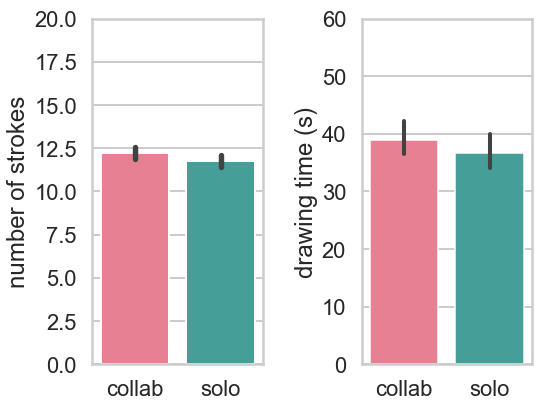

In [100]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid')
plt.subplot(121)
sns.barplot(data=M,
            x='condition',
            y='numStrokes',
            order=['collab','solo'],            
            palette='husl')
plt.xlabel('')
plt.ylabel('number of strokes')
plt.ylim(0,20)

plt.subplot(122)
M['sketchDurationSec'] = M['sketchDuration'].apply(lambda x: x/1000)
sns.set_style('whitegrid')
sns.set_context('talk')
sns.barplot(data=M,
            x='condition',
            y='sketchDurationSec',
            order=['collab','solo'],
            palette='husl')
plt.xlabel('')
plt.ylabel('drawing time (s)')
plt.ylim(0,60)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir,'sketch_effort_cost.pdf'))

In [95]:
def get_bootstrapped_diff(M,var='numStrokes'):
    ## aggregate by game & condition
    M2 = M.groupby(['gameID','condition'])[var].mean().reset_index()
    ## pivot long to wide
    M3 = M2.pivot(index='gameID', columns='condition', values=var).reset_index()
    M3['diff'] = M3['collab'] - M3['solo']

    ## bootstrap
    nIter = 1000
    boot_diff = []
    for currIter in np.arange(nIter):
        print 'On bootstrap iteration {}'.format(currIter+1)
        clear_output(wait=True)
        boot_dist = M3['diff'].sample(n=len(M3),replace=True,random_state=currIter).values
        boot_diff.append(boot_dist)
    
    lb = np.percentile(boot_diff,2.5)
    ub = np.percentile(boot_diff,97.5)        

    print var        
    print 'true diff: {} |  95% CI: [{}, {}]'.format(np.mean(M3['diff']).round(4),lb,ub)  
    print 'mean collab: {} | mean solo: {}'.format(M3['collab'].values.mean(),M3['solo'].values.mean())
    return M3, lb,ub

In [96]:
M3,lb,ub = get_bootstrapped_diff(M,var='numStrokes')

numStrokes
true diff: 0.488 |  95% CI: [-5.625, 5.0625]
mean collab: 12.2375 | mean solo: 11.7494907407


In [ ]:
M3,lb,ub = get_bootstrapped_diff(M,var='sketchDurationSec')